<a href="https://colab.research.google.com/github/mirkhalilrehman/Jaundiced-and-Normal-Eyes-Classification/blob/main/jaundiced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [117]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
import os
dataset_path = '/content/drive/My Drive/jaundiced_normal'

print(os.listdir(dataset_path))

['Jaundiced Eyes', 'Normal Eyes']


In [119]:
import torch
import numpy as np
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [120]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [121]:
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
classes = dataset.classes
print(f"Classes: {classes}")

Classes: ['Jaundiced Eyes', 'Normal Eyes']


In [122]:
train_data, test_data = train_test_split(dataset, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

In [123]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

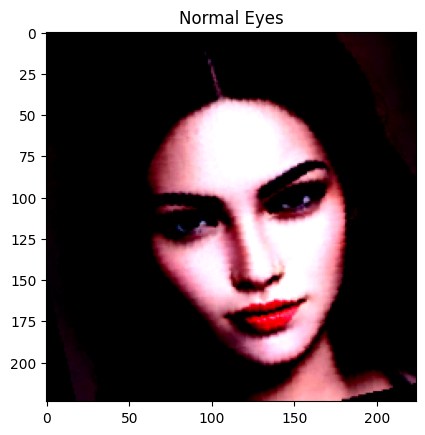

In [124]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
plt.imshow(images[0].permute(1, 2, 0))
plt.title(classes[labels[0]])
plt.show()

In [125]:
class CustomMobileNetV2(nn.Module):
    def __init__(self, use_pretrained=True):
        super(CustomMobileNetV2, self).__init__()
        self.base_model = models.mobilenet_v2(pretrained=use_pretrained)
        for param in self.base_model.features.parameters():
            param.requires_grad = False

        in_features = self.base_model.last_channel
        self.base_model.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ELU(),
            nn.Dropout(0.4),
            nn.Linear(512, 64),
            nn.ELU(),
            nn.Dropout(0.4),
            nn.Linear(64, len(classes))
        )

    def forward(self, x):
        return self.base_model(x)

In [126]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CustomMobileNetV2()
model.to(device)
print(model)

CustomMobileNetV2(
  (base_model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kerne

In [127]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)

In [128]:
n_epochs = 50
patience = 8
train_losses, valid_losses = [], []
valid_loss_min = np.Inf
epochs_no_improve = 0

for epoch in range(1, n_epochs + 1):
    train_loss, valid_loss = 0.0, 0.0

    # Training phase
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

    # Validation phase
    model.eval()
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)

    # Average losses
    train_loss /= len(train_loader.dataset)
    valid_loss /= len(val_loader.dataset)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch}: Training Loss: {train_loss:.6f}, Validation Loss: {valid_loss:.6f}")

    # Save model if validation loss decreases
    if valid_loss <= valid_loss_min:
        print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
        torch.save(model.state_dict(), 'jaundiced_normal.pt')
        valid_loss_min = valid_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"No improvement in validation loss for {epochs_no_improve} epoch(s).")

    # Early stopping
    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch}.")
        break

    # Adjust learning rate
    scheduler.step(valid_loss)

Epoch 1: Training Loss: 0.673196, Validation Loss: 0.691882
Validation loss decreased (inf --> 0.691882). Saving model...
Epoch 2: Training Loss: 0.633294, Validation Loss: 0.692390
No improvement in validation loss for 1 epoch(s).
Epoch 3: Training Loss: 0.608353, Validation Loss: 0.677447
Validation loss decreased (0.691882 --> 0.677447). Saving model...
Epoch 4: Training Loss: 0.590424, Validation Loss: 0.653521
Validation loss decreased (0.677447 --> 0.653521). Saving model...
Epoch 5: Training Loss: 0.567823, Validation Loss: 0.616459
Validation loss decreased (0.653521 --> 0.616459). Saving model...
Epoch 6: Training Loss: 0.537137, Validation Loss: 0.608619
Validation loss decreased (0.616459 --> 0.608619). Saving model...
Epoch 7: Training Loss: 0.510414, Validation Loss: 0.590288
Validation loss decreased (0.608619 --> 0.590288). Saving model...
Epoch 8: Training Loss: 0.473984, Validation Loss: 0.564273
Validation loss decreased (0.590288 --> 0.564273). Saving model...
Epoch 

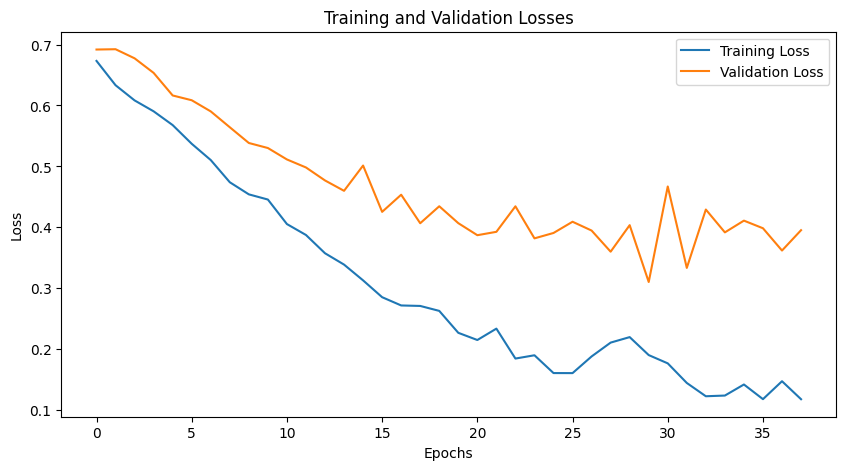

In [129]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [130]:
model.eval()
correct, total = 0, 0
y_true, y_pred = [], []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, preds = torch.max(output, 1)
        correct += (preds == target).sum().item()
        total += target.size(0)
        y_true.extend(target.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 88.89%


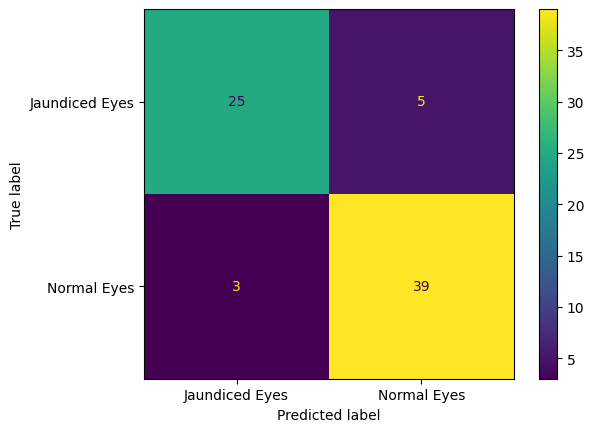

In [131]:
cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()